In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Description

# Imports

In [2]:
import logging
import os

import pandas as pd
import seaborn as sns
from tqdm.autonotebook import tqdm

import core.config as cconfig
import core.finance as cofinanc
import dataflow.core as dtfcore
import dataflow.pipelines.execution.execution_pipeline as dtfpexexpi
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hparquet as hparque
import helpers.hprint as hprint
import helpers.hs3 as hs3
import im_v2.ccxt.data.client as icdc
import im_v2.crypto_chassis.data.client as iccdc

/tmp/ipykernel_1017/500288826.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-4510acd2-e0cf-4e0c-9231-1894a08e7033.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask3991_Estimate_market_impact_1'
  hash='3690b4344'
  # Last commits:
    * 3690b4344 paul     Checkpoint                                                        (   2 hours ago) Mon Mar 13 17:51:24 2023  (HEAD -> CmTask3991_Estimate_market_impact_1, origin/CmTask3991_Estimate_market_impact_1)
    * f23ce7424 paul     Checkpoint                                                        (   4 hours ago) Mon Mar 13 15:05:54 20

# Client general arguments

In [4]:
s3_bucket_path = hs3.get_s3_bucket_path("ck")
root_dir = os.path.join(s3_bucket_path, "v3")
partition_mode = "by_year_month"
data_snapshot = ""
version = "v1_0_0"
resample_1min = False
aws_profile = "ck"
full_symbols = ["binance::BTC_USDT", "binance::ETH_USDT"]
filter_data_mode = "assert"

# OHLCV

## Read data

Get OHLCV data for 01-08-2022 to 02-03-2023

In [5]:
ohlcv_universe_version = (
    "v1"  # Get the smallest universe that contains BTC and ETH
)
ohlcv_dataset = "ohlcv"
ohlcv_contract_type = "spot"
ohlcv_tag = "downloaded_1min"

In [6]:
ohlcv_ccxt_client = icdc.CcxtHistoricalPqByTileClient(
    ohlcv_universe_version,
    root_dir,
    partition_mode,
    ohlcv_dataset,
    ohlcv_contract_type,
    data_snapshot,
    tag=ohlcv_tag,
    version=version,
    resample_1min=resample_1min,
    aws_profile=aws_profile,
)

In [7]:
ohlcv_start_ts = pd.Timestamp("2022-08-01", tz="UTC")
ohlcv_end_ts = pd.Timestamp("2023-03-02", tz="UTC")
ohlcv_asset_ids = ohlcv_ccxt_client.get_asset_ids_from_full_symbols(full_symbols)
ohlcv_columns = None

In [8]:
ohlcv = ohlcv_ccxt_client.read_data(
    full_symbols, ohlcv_start_ts, ohlcv_end_ts, ohlcv_columns, filter_data_mode
)
ohlcv["asset_id"] = ohlcv["full_symbol"].apply(
    lambda x: ohlcv_ccxt_client.get_asset_ids_from_full_symbols([x])[0]
)

In [9]:
ohlcv.shape

(613442, 8)

In [10]:
ohlcv.head()

,full_symbol,open,high,low,close,volume,knowledge_timestamp,asset_id
timestamp,,,,,,,,
2022-08-01 00:00:00+00:00,binance::BTC_USDT,23296.36,23296.78,23262.27,23280.77,202.57486,2023-02-10 21:20:12.817984+00:00,1467591036
2022-08-01 00:00:00+00:00,binance::ETH_USDT,1678.12,1678.35,1672.63,1675.72,2621.29920,2023-02-10 21:19:47.895909+00:00,1464553467
2022-08-01 00:01:00+00:00,binance::BTC_USDT,23280.77,23317.68,23263.01,23313.09,153.76413,2023-02-10 21:20:12.817984+00:00,1467591036
2022-08-01 00:01:00+00:00,binance::ETH_USDT,1675.72,1680.88,1674.23,1680.88,894.89080,2023-02-10 21:19:47.895909+00:00,1464553467
2022-08-01 00:02:00+00:00,binance::BTC_USDT,23316.78,23317.72,23271.23,23287.89,119.87883,2023-02-10 21:20:12.817984+00:00,1467591036


In [11]:
pivot_ohlcv = ohlcv.pivot(
    columns="full_symbol",
    values=["open", "high", "low", "close", "volume"],
)
pivot_ohlcv.head()

open                                high                                 low                               close                              volume                  
full_symbol               binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                    
2022-08-01 00:00:00+00:00          23296.36           1678.12          23296.78           1678.35          23262.27           1672.63          23280.77           1675.72         202.57486         2621.2992
2022-08-01 00:01:00+00:00          23280.77           1675.72          23317.68           1680.88          23263.01           1674.23          23313.09           1680.88         153.76413          894.8908
2022-08-01 00:02:00+00:00          23316.78           1680.87          23317.72           1681.37          23271.23           1676.23          23287.89           1678.22         119.87883         1267.1040
2022-08-01 00:03:00+00:00          23287.89           1678.22          23291.08           1678.61          23263.02           1675.41          23278.59           1677.37         100.59952          410.1610
2022-08-01 00:04:00+00:00          23275.48           1677.36          23297.48           1679.44          23266.27           1674.82          23277.42           1677.29          74.75517         1010.7250

## Resample to 1 hour

In [12]:
ohlcv_resampling_node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.resample_bars,
    **{
        "in_col_groups": [
            ("close",),
            ("volume",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": "1H",
            "resampling_groups": [
                ({"close": "close"}, "mean", {}),
                (
                    {"volume": "volume"},
                    "sum",
                    {"min_count": 1},
                ),
                (
                    {
                        "close": "twap",
                    },
                    "mean",
                    {},
                ),
            ],
            "vwap_groups": [
                ("close", "volume", "vwap"),
            ],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    },
)

In [13]:
resampled_ohlcv = ohlcv_resampling_node.fit(pivot_ohlcv)["df_out"]

In [14]:
resampled_ohlcv.head()

close                                twap                              volume                                vwap                  
                          binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                
2022-08-01 00:00:00+00:00      23280.770000       1675.720000      23280.770000       1675.720000         202.57486         2621.2992      23280.770000       1675.720000
2022-08-01 01:00:00+00:00      23333.483833       1682.991833      23333.483833       1682.991833        4949.61967        27300.0624      23330.242753       1680.943092
2022-08-01 02:00:00+00:00      23397.410333       1692.652333      23397.410333       1692.652333        3845.98988        19010.0221      23397.787571       1692.261101
2022-08-01 03:00:00+00:00      23417.523667       1695.608333      23417.523667       1695.608333        3501.38707        17711.0411      23420.142953       1696.006052
2022-08-01 04:00:00+00:00      23358.964833       1689.225000      23358.964833       1689.225000        3136.74776        14037.9544      23360.667792       1689.150146

## Average volume by hour of the day

In [15]:
# Extract BTC and ETH dataframes.
resampled_ohlcv_btc = cofinanc.get_asset_slice(
    resampled_ohlcv, "binance::BTC_USDT"
).reset_index()
resampled_ohlcv_eth = cofinanc.get_asset_slice(
    resampled_ohlcv, "binance::ETH_USDT"
).reset_index()

In [16]:
# Get averages by hour.
resampled_ohlcv_btc_by_hour = resampled_ohlcv_btc.groupby(
    resampled_ohlcv_btc.timestamp.dt.hour
).mean()
resampled_ohlcv_eth_by_hour = resampled_ohlcv_eth.groupby(
    resampled_ohlcv_eth.timestamp.dt.hour
).mean()

/tmp/ipykernel_1017/1134922834.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_ohlcv_btc_by_hour = resampled_ohlcv_btc.groupby(
/tmp/ipykernel_1017/1134922834.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_ohlcv_eth_by_hour = resampled_ohlcv_eth.groupby(


In [17]:
display(resampled_ohlcv_btc_by_hour)
display(resampled_ohlcv_eth_by_hour)

,close,twap,volume,vwap
timestamp,,,,
0,19978.333970,19978.333970,9126.462828,19978.220336
1,19970.112710,19970.112710,10923.987056,19971.405525
2,19980.334641,19980.334641,9485.794441,19980.773428
3,19978.220525,19978.220525,9232.200157,19978.466127
4,19984.820186,19984.820186,8415.085191,19985.182832
5,19989.544986,19989.544986,7987.567896,19990.811486
6,19991.261239,19991.261239,8189.979976,19990.752654
7,19988.394499,19988.394499,8922.416371,19987.347528
8,19987.377088,19987.377088,9820.649820,19986.175472


,close,twap,volume,vwap
timestamp,,,,
0,1453.684396,1453.684396,22110.959564,1453.653294
1,1453.466250,1453.466250,27056.019420,1453.742369
2,1454.709196,1454.709196,23034.827941,1454.712760
3,1454.444661,1454.444661,21546.703759,1454.388129
4,1454.944073,1454.944073,19627.522394,1454.926403
5,1455.536645,1455.536645,17133.038485,1455.772425
6,1455.663242,1455.663242,17559.440382,1455.638450
7,1455.376750,1455.376750,20449.532328,1455.217499
8,1455.228233,1455.228233,22468.035932,1455.014643


### Get total volume percentage by hour

In [18]:
# Get hourly average volume as percentage of total average day volume.
resampled_ohlcv_btc_by_hour["normalized_volume"] = resampled_ohlcv_btc_by_hour[
    "volume"
].apply(lambda x: x / resampled_ohlcv_btc_by_hour["volume"].sum())
#
resampled_ohlcv_eth_by_hour["normalized_volume"] = resampled_ohlcv_eth_by_hour[
    "volume"
].apply(lambda x: x / resampled_ohlcv_eth_by_hour["volume"].sum())

In [19]:
display(resampled_ohlcv_btc_by_hour)
display(resampled_ohlcv_eth_by_hour)

,close,twap,volume,vwap,normalized_volume
timestamp,,,,,
0,19978.333970,19978.333970,9126.462828,19978.220336,0.035416
1,19970.112710,19970.112710,10923.987056,19971.405525,0.042392
2,19980.334641,19980.334641,9485.794441,19980.773428,0.036811
3,19978.220525,19978.220525,9232.200157,19978.466127,0.035827
4,19984.820186,19984.820186,8415.085191,19985.182832,0.032656
5,19989.544986,19989.544986,7987.567896,19990.811486,0.030997
6,19991.261239,19991.261239,8189.979976,19990.752654,0.031782
7,19988.394499,19988.394499,8922.416371,19987.347528,0.034625
8,19987.377088,19987.377088,9820.649820,19986.175472,0.038110


,close,twap,volume,vwap,normalized_volume
timestamp,,,,,
0,1453.684396,1453.684396,22110.959564,1453.653294,0.037162
1,1453.466250,1453.466250,27056.019420,1453.742369,0.045473
2,1454.709196,1454.709196,23034.827941,1454.712760,0.038714
3,1454.444661,1454.444661,21546.703759,1454.388129,0.036213
4,1454.944073,1454.944073,19627.522394,1454.926403,0.032988
5,1455.536645,1455.536645,17133.038485,1455.772425,0.028795
6,1455.663242,1455.663242,17559.440382,1455.638450,0.029512
7,1455.376750,1455.376750,20449.532328,1455.217499,0.034369
8,1455.228233,1455.228233,22468.035932,1455.014643,0.037762


<AxesSubplot: xlabel='timestamp'>

<AxesSubplot: xlabel='timestamp'>

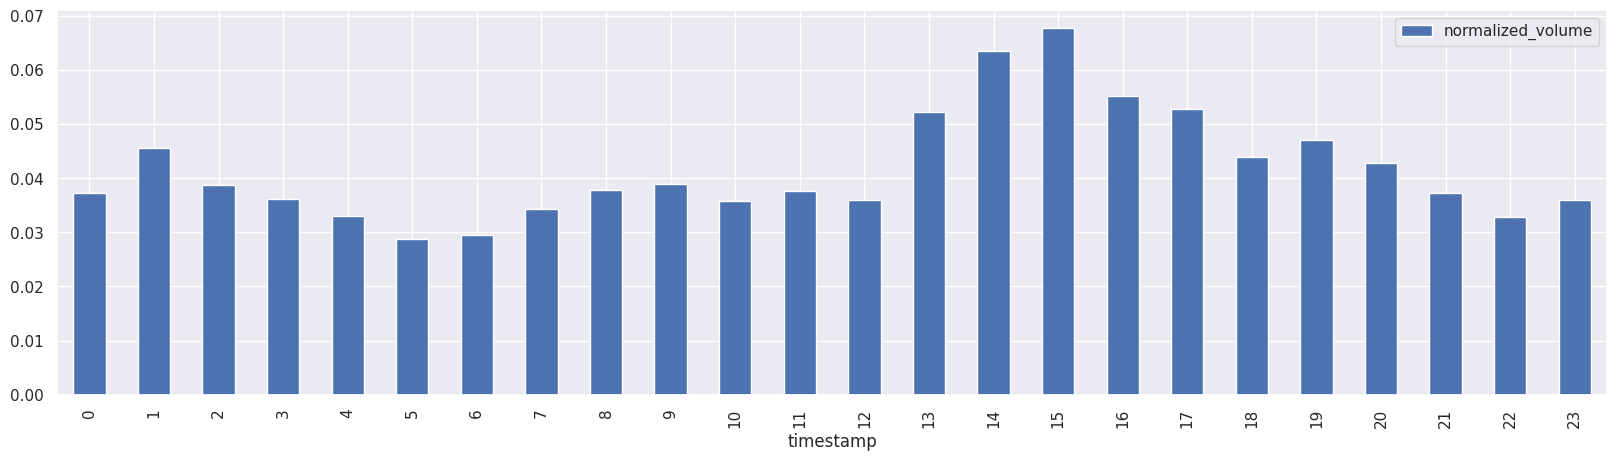

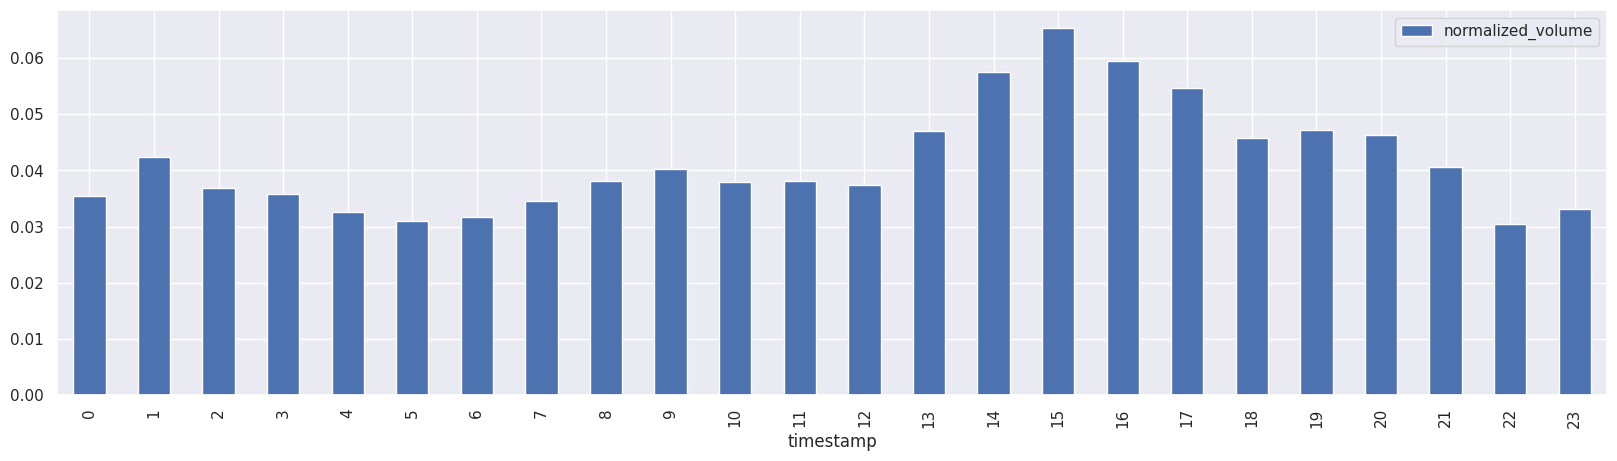

In [20]:
display(resampled_ohlcv_eth_by_hour[["normalized_volume"]].plot(kind="bar"))
display(resampled_ohlcv_btc_by_hour[["normalized_volume"]].plot(kind="bar"))

### Get total volume by day of the week

In [21]:
# BTC.
resampled_ohlcv_btc_by_day = resampled_ohlcv_btc.groupby(
    resampled_ohlcv_btc.timestamp.dt.weekday
).mean()
resampled_ohlcv_btc_by_day

/tmp/ipykernel_1017/3657857788.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_ohlcv_btc_by_day = resampled_ohlcv_btc.groupby(


,close,twap,volume,vwap
timestamp,,,,
0,20041.049730,20041.049730,11186.051844,20041.248446
1,20049.227576,20049.227576,12209.112373,20048.856509
2,19968.973756,19968.973756,12369.171513,19968.747628
3,19947.017175,19947.017175,12244.495199,19947.240784
4,19887.288375,19887.288375,12206.256393,19886.793558
5,19970.919925,19970.919925,7469.945205,19970.852969
6,19974.735863,19974.735863,7351.907153,19974.118225


In [22]:
# ETH.
resampled_ohlcv_eth_by_day = resampled_ohlcv_eth.groupby(
    resampled_ohlcv_eth.timestamp.dt.weekday
).mean()
resampled_ohlcv_eth_by_day

/tmp/ipykernel_1017/4292538671.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_ohlcv_eth_by_day = resampled_ohlcv_eth.groupby(


,close,twap,volume,vwap
timestamp,,,,
0,1453.054049,1453.054049,25032.077255,1452.989497
1,1456.152072,1456.152072,28551.874933,1456.097764
2,1451.256073,1451.256073,30531.931221,1451.236904
3,1457.783801,1457.783801,28337.128709,1457.734793
4,1453.006854,1453.006854,27361.503092,1452.962189
5,1456.959486,1456.959486,17180.817049,1456.930535
6,1452.715983,1452.715983,16211.764558,1452.540667


### Get percentage of the total volume by day of the week

In [23]:
# Get daily average volume as percentage of total average weekly volume.
resampled_ohlcv_btc_by_day["normalized_volume"] = resampled_ohlcv_btc_by_day[
    "volume"
].apply(lambda x: x / resampled_ohlcv_btc_by_day["volume"].sum())
#
resampled_ohlcv_eth_by_day["normalized_volume"] = resampled_ohlcv_eth_by_day[
    "volume"
].apply(lambda x: x / resampled_ohlcv_eth_by_day["volume"].sum())

<AxesSubplot: xlabel='timestamp'>

<AxesSubplot: xlabel='timestamp'>

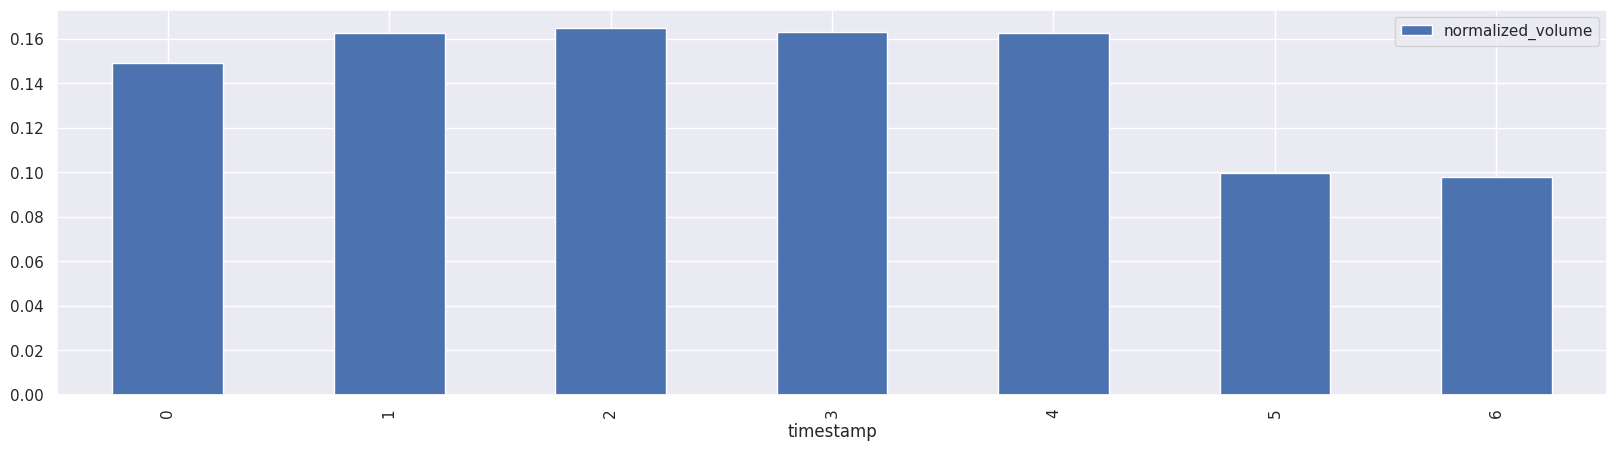

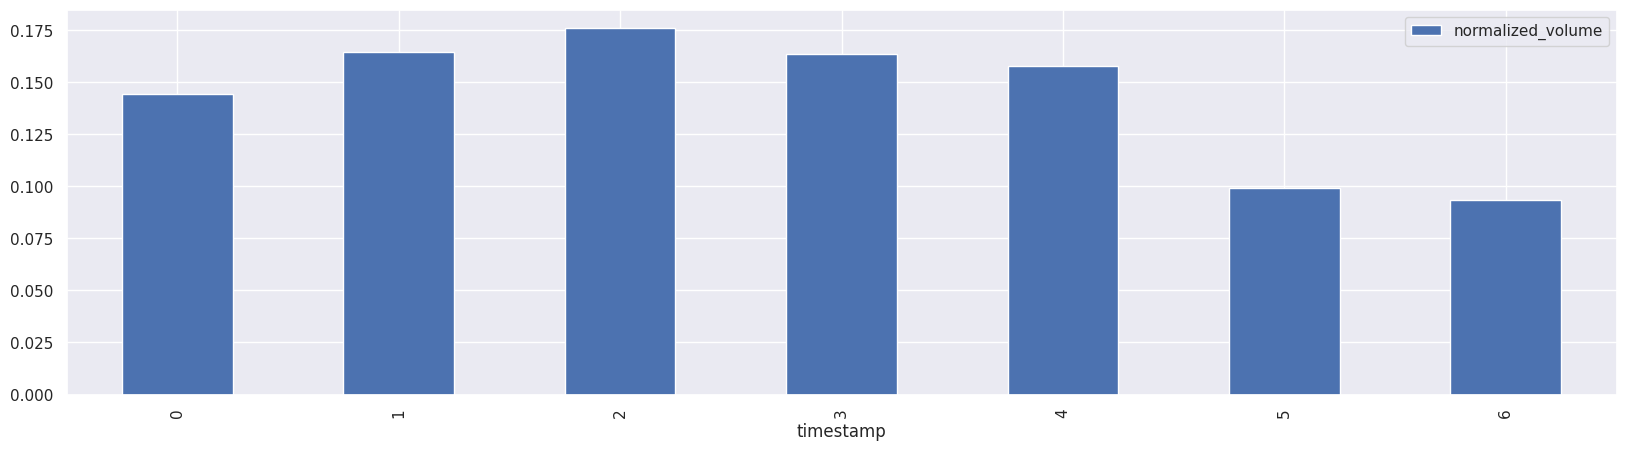

In [24]:
display(resampled_ohlcv_btc_by_day[["normalized_volume"]].plot(kind="bar"))
display(resampled_ohlcv_eth_by_day[["normalized_volume"]].plot(kind="bar"))

# Bid/ask

## Functions

Factored out common operations for loading and transformation of futures/spot bid/ask data.

In [25]:
def load_data(data_type: str) -> pd.DataFrame:
    """
    Load futures/spot data for the experiment.
    """
    #
    bid_ask_start_ts = pd.Timestamp("2023-02-01 00:00:00", tz="UTC")
    bid_ask_end_ts = pd.Timestamp("2023-02-28 23:59:59", tz="UTC")
    #
    if data_type == "futures":
        # Load futures data for February 2023.
        bid_ask_universe_version = "v3"
        bid_ask_contract_type = "futures"
        bid_ask_tag = "downloaded_1sec"
        bid_ask_dataset = "bid_ask"
        bid_ask_columns = [
            "full_symbol",
            "bid_price_l1",
            "ask_price_l1",
            "bid_size_l1",
            "ask_size_l1",
            "knowledge_timestamp",
        ]
        cc_bid_ask_client = iccdc.CryptoChassisHistoricalPqByTileClient(
            bid_ask_universe_version,
            root_dir,
            partition_mode,
            bid_ask_dataset,
            bid_ask_contract_type,
            data_snapshot,
            version=version,
            tag=bid_ask_tag,
            aws_profile=aws_profile,
            resample_1min=resample_1min,
        )
        data = cc_bid_ask_client.read_data(
            full_symbols,
            bid_ask_start_ts,
            bid_ask_end_ts,
            bid_ask_columns,
            filter_data_mode,
        )
        col_rename_mapping = {}
        for c in data.columns:
            col_rename_mapping[c] = c.replace("_l1", "")
        data = data.rename(col_rename_mapping, axis=1)
    elif data_type == "spot":
        # Load spot data for November 2022 directly from parquet dataset.
        # Note: this is the only complete data range for 1 sec spot data we have right now (2022-03-06).
        path = "s3://cryptokaizen-data/reorg/daily_staged.airflow.pq/bid_ask/crypto_chassis.downloaded_1sec/binance/"
        data = hparque.from_parquet(path, aws_profile=aws_profile)
        data["full_symbol"] = data["currency_pair"].apply(
            lambda x: "binance::" + x
        )
        data = data[data["full_symbol"].isin(full_symbols)]
        data = data[
            [
                "bid_price",
                "bid_size",
                "ask_price",
                "ask_size",
                "currency_pair",
                "full_symbol",
            ]
        ]
        data = data.loc[data.index <= pd.Timestamp("2022-11-30 23:59:59+00:00")]
    else:
        raise ValueError("Incorrect data type, use 'futures' or 'spot'")
    return data


def create_execution_pipeline(subsample_freq: int):
    """
    Get DAG for computing execution quality.
    """
    dag_builder = dtfpexexpi.ExecutionPipeline()
    #
    config = dag_builder.get_config_template()
    # Set up `overwrite` mode to allow reassignment of values.
    # Note: by default the `update_mode` does not allow overwrites,
    # but they are required by the FeaturePipeline.
    config.update_mode = "overwrite"
    _LOG.debug("config from dag_builder=%s", config)
    # Initialize config.
    config["load_data"] = cconfig.Config.from_dict(
        {
            "source_node_name": "FunctionDataSource",
            "source_node_kwargs": {
                "func": get_data,
            },
        }
    )
    config[
        "generate_limit_orders", "transformer_kwargs", "sell_spread_frac_offset"
    ] = 0.0
    config[
        "generate_limit_orders", "transformer_kwargs", "subsample_freq"
    ] = f"{subsample_freq}s"
    config[
        "generate_limit_orders", "transformer_kwargs", "ffill_limit"
    ] = subsample_freq
    #
    _LOG.debug("config after patching=%s", config)
    dag = dag_builder.get_dag(config)
    return dag


def calculate_and_apply_weights(resampled_bid_ask: pd.DataFrame):
    """
    Apply normalized OHLCV volume by hour as weights to bid price.
    """
    # Get corresponding hour for each 1-hour entry.
    # Slice asset-specific dataframes.
    resampled_bid_ask_btc = cofinanc.get_asset_slice(
        resampled_bid_ask, "binance::BTC_USDT"
    ).reset_index()
    resampled_bid_ask_btc["hour"] = resampled_bid_ask_btc.reset_index()[
        "timestamp"
    ].dt.hour
    resampled_bid_ask_eth = cofinanc.get_asset_slice(
        resampled_bid_ask, "binance::ETH_USDT"
    ).reset_index()
    resampled_bid_ask_eth["hour"] = resampled_bid_ask_eth.reset_index()[
        "timestamp"
    ].dt.hour
    # Convert weights to dicts by asset.
    btc_hour_weights = resampled_ohlcv_btc_by_hour["normalized_volume"].to_dict()
    eth_hour_weights = resampled_ohlcv_eth_by_hour["normalized_volume"].to_dict()
    # Replace hour with corresponding weight.
    resampled_bid_ask_btc["weights"] = resampled_bid_ask_btc["hour"].map(
        btc_hour_weights
    )
    resampled_bid_ask_eth["weights"] = resampled_bid_ask_eth["hour"].map(
        eth_hour_weights
    )
    # Apply weights.
    resampled_bid_ask_btc["weighted_bid_price"] = (
        resampled_bid_ask_btc["bid_price"] * resampled_bid_ask_btc["weights"]
    )
    resampled_bid_ask_eth["weighted_bid_price"] = (
        resampled_bid_ask_eth["bid_price"] * resampled_bid_ask_eth["weights"]
    )
    return resampled_bid_ask_btc, resampled_bid_ask_eth


def get_data():
    """
    Get pivot data (for DataSource node).
    """
    return pivot_bid_ask


def get_sum_bid_price_by_day(resampled_bid_ask: pd.DataFrame):
    """
    Resample data by 1D and get a sum.
    """
    resampled_bid_ask = resampled_bid_ask.set_index("timestamp")
    by_day_bid_ask = (
        resampled_bid_ask["weighted_bid_price"].resample(rule="D").sum()
    )
    return by_day_bid_ask


def apply_weights_to_execution_pipeline(df_out: pd.DataFrame):
    """
    Apply normalized volume weights to hourly execution quality data.
    """
    df_out_btc = cofinanc.get_asset_slice(
        df_out, "binance::BTC_USDT"
    ).reset_index()
    df_out_eth = cofinanc.get_asset_slice(
        df_out, "binance::ETH_USDT"
    ).reset_index()
    df_out_btc["hour"] = df_out_btc.reset_index().timestamp.dt.hour
    df_out_eth["hour"] = df_out_eth.reset_index().timestamp.dt.hour
    # Convert weights to dicts by asset.
    btc_hour_weights = resampled_ohlcv_btc_by_hour["normalized_volume"].to_dict()
    eth_hour_weights = resampled_ohlcv_eth_by_hour["normalized_volume"].to_dict()
    # Replace hour with corresponding weight.
    df_out_btc["weights"] = df_out_btc["hour"].map(btc_hour_weights)
    df_out_eth["weights"] = df_out_eth["hour"].map(eth_hour_weights)
    # Apply weights.
    df_out_btc["weighted_sell_trade_price"] = (
        df_out_btc["sell_trade_price"] * df_out_btc["weights"]
    )
    df_out_eth["weighted_sell_trade_price"] = (
        df_out_eth["sell_trade_price"] * df_out_eth["weights"]
    )
    df_out_btc = df_out_btc.set_index("timestamp")
    df_out_eth = df_out_eth.set_index("timestamp")
    return df_out_btc, df_out_eth

## Futures

### Read data

In [26]:
# Load futures data for February 2023.
bid_ask = load_data("futures")

### Transform

In [27]:
# Add spread column.
bid_ask["quoted_spread"] = bid_ask["ask_price"] - bid_ask["bid_price"]
bid_ask

,full_symbol,bid_price,ask_price,bid_size,ask_size,knowledge_timestamp,quoted_spread
timestamp,,,,,,,
2023-02-01 00:00:00+00:00,binance::BTC_USDT,23121.40,23121.50,2.178,22.425,2023-02-02 11:02:01.280139+00:00,0.10
2023-02-01 00:00:00+00:00,binance::ETH_USDT,1585.02,1585.03,0.483,125.915,2023-02-02 11:02:47.292347+00:00,0.01
2023-02-01 00:00:01+00:00,binance::BTC_USDT,23119.40,23119.50,11.939,6.736,2023-02-02 11:02:01.280139+00:00,0.10
2023-02-01 00:00:01+00:00,binance::ETH_USDT,1585.00,1585.01,1.029,243.555,2023-02-02 11:02:47.292347+00:00,0.01
2023-02-01 00:00:02+00:00,binance::BTC_USDT,23119.40,23119.50,12.289,6.736,2023-02-02 11:02:01.280139+00:00,0.10
...,...,...,...,...,...,...,...
2023-02-28 23:59:57+00:00,binance::ETH_USDT,1604.32,1604.33,104.035,42.712,2023-03-01 11:02:44.569426+00:00,0.01
2023-02-28 23:59:58+00:00,binance::BTC_USDT,23119.40,23119.50,20.229,17.429,2023-03-01 11:02:02.771894+00:00,0.10
2023-02-28 23:59:58+00:00,binance::ETH_USDT,1604.32,1604.33,133.995,6.371,2023-03-01 11:02:44.569426+00:00,0.01


In [28]:
pivot_bid_ask = bid_ask.pivot(
    columns="full_symbol",
    values=[
        "bid_price",
        "ask_price",
        "bid_size",
        "ask_size",
        "quoted_spread",
    ],
)
pivot_bid_ask.head()

bid_price                           ask_price                            bid_size                            ask_size                       quoted_spread                  
full_symbol               binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                    
2023-02-01 00:00:00+00:00           23121.4           1585.02           23121.5           1585.03             2.178             0.483            22.425           125.915               0.1              0.01
2023-02-01 00:00:01+00:00           23119.4           1585.00           23119.5           1585.01            11.939             1.029             6.736           243.555               0.1              0.01
2023-02-01 00:00:02+00:00           23119.4           1585.00           23119.5           1585.01            12.289             1.029             6.736           224.839               0.1              0.01
2023-02-01 00:00:03+00:00           23119.4           1585.00           23119.5           1585.01            12.289             1.040             6.736           223.639               0.1              0.01
2023-02-01 00:00:04+00:00           23119.4               NaN           23119.5               NaN            12.290               NaN             6.734               NaN               0.1               NaN

In [29]:
# Resample futures to 1 hour.
bid_ask_resampling_node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.resample_bars,
    **{
        "in_col_groups": [
            ("bid_price",),
            ("ask_price",),
            ("bid_size",),
            ("ask_size",),
            ("quoted_spread",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": "1H",
            "resampling_groups": [
                # 1 resampling per aggregation group -> 1 transform function, 1 dict
                (
                    {
                        "bid_price": "bid_price",
                        "ask_price": "ask_price",
                        "bid_size": "bid_size",
                        "ask_size": "ask_size",
                        "quoted_spread": "quoted_spread",
                    },
                    "mean",
                    {},
                ),
            ],
            "vwap_groups": [],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    },
)
resampled_bid_ask = bid_ask_resampling_node.fit(pivot_bid_ask)["df_out"]

In [30]:
# Apply weights to bid price based on OHLCV average hourly volume.
resampled_bid_ask_btc, resampled_bid_ask_eth = calculate_and_apply_weights(
    resampled_bid_ask
)

<AxesSubplot: xlabel='timestamp'>

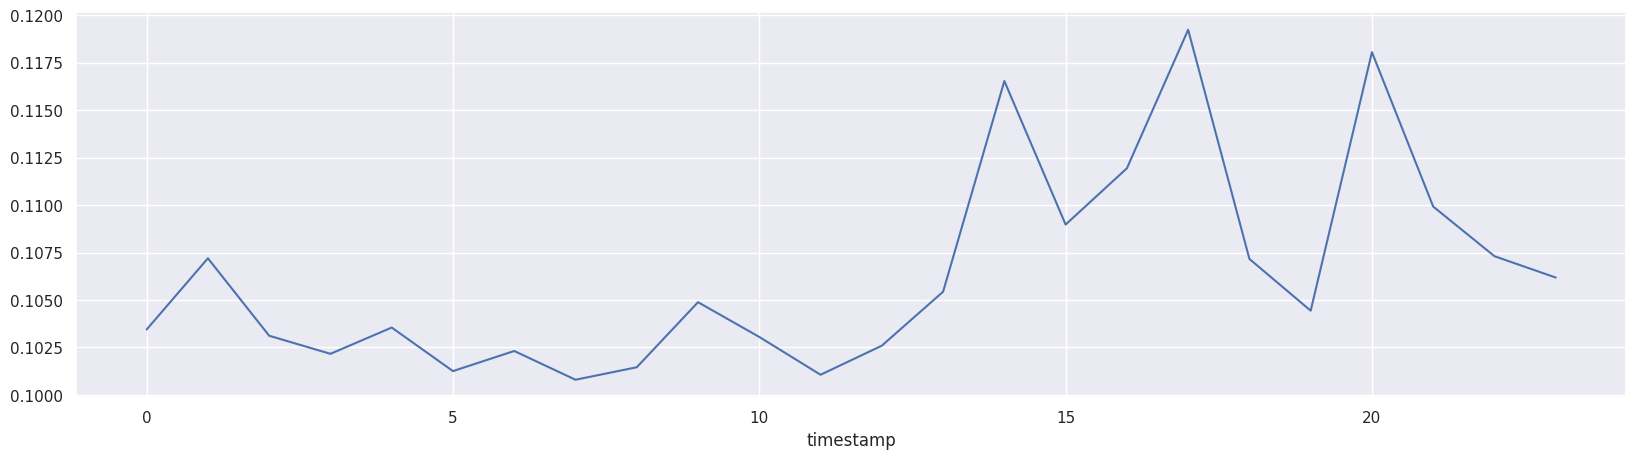

In [31]:
# Plot average spread per hour.
resampled_bid_ask_btc["quoted_spread"].groupby(
    resampled_bid_ask_btc.timestamp.dt.hour
).mean().plot()

<AxesSubplot: xlabel='timestamp'>

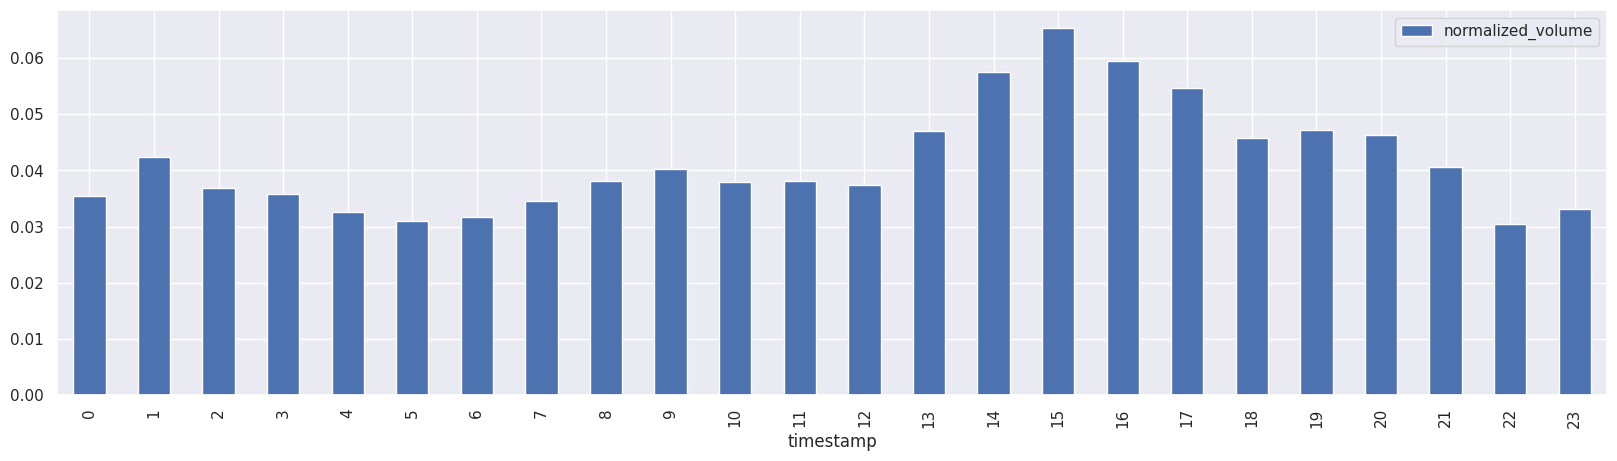

In [32]:
# Plot normalized volume by hour (for reference with average spread).
resampled_ohlcv_btc_by_hour[["normalized_volume"]].plot(kind="bar")

In [33]:
by_day_bid_ask_btc = get_sum_bid_price_by_day(resampled_bid_ask_btc)
by_day_bid_ask_eth = get_sum_bid_price_by_day(resampled_bid_ask_eth)

<AxesSubplot: xlabel='timestamp'>

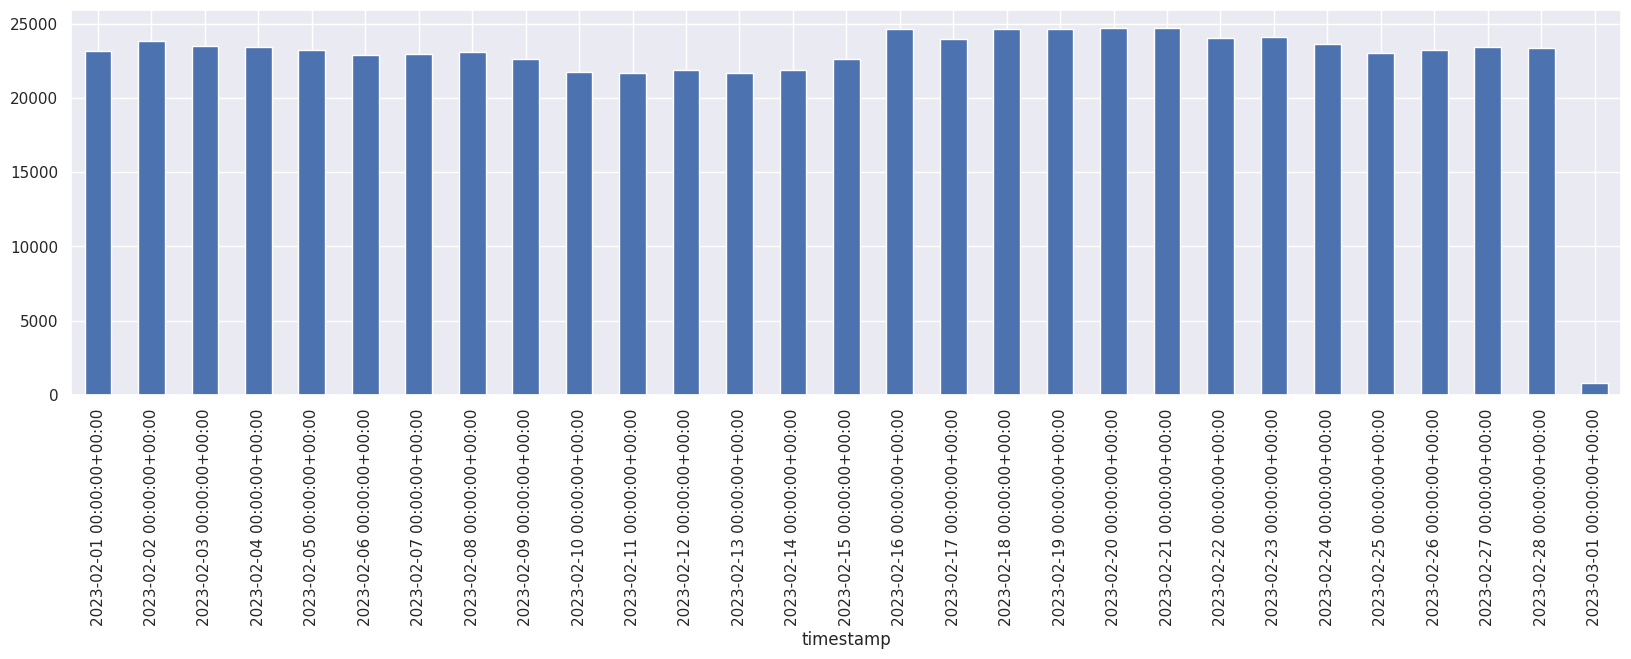

In [34]:
by_day_bid_ask_btc.plot(kind="bar")

### Execution pipeline

In [35]:
# Run execution quality pipeline with subsampling=60.
dag = create_execution_pipeline(60)
df_out = dag.run_leq_node("compute_bid_ask_execution_quality", "fit")["df_out"]

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [36]:
# Apply weights to sell price.
df_out_btc, df_out_eth = apply_weights_to_execution_pipeline(df_out)

In [37]:
# Get sell and weighted bid prices by day.
sell_trade_price_eth = (
    df_out_eth["weighted_sell_trade_price"].resample(rule="D").sum()
)

bid_price_eth_by_day = (
    resampled_bid_ask_eth.set_index("timestamp")["weighted_bid_price"]
    .resample(rule="D")
    .sum()
)

### Check results with different subsamples.

In [38]:
# Sweep over multiple subsampling values.
frequencies = [1, 60, 300, 900, 3600]
result_dict = {}
for f in frequencies:
    dag = create_execution_pipeline(f)
    df = dag.run_leq_node("compute_bid_ask_execution_quality", "fit")["df_out"]
    result_dict[f] = df

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


## Spot

In [39]:
# Load spot data for November 2022.
bid_ask = load_data("spot")

### Transform

In [40]:
# Add spread column.
bid_ask["quoted_spread"] = bid_ask["ask_price"] - bid_ask["bid_price"]
bid_ask

,bid_price,bid_size,ask_price,ask_size,currency_pair,full_symbol,quoted_spread
timestamp,,,,,,,
2022-11-03 00:00:00+00:00,20150.65,0.00995,20151.89,0.95464,BTC_USDT,binance::BTC_USDT,1.24
2022-11-03 00:00:01+00:00,20151.01,0.00470,20152.00,0.00100,BTC_USDT,binance::BTC_USDT,0.99
2022-11-03 00:00:02+00:00,20150.28,0.04457,20151.39,0.02819,BTC_USDT,binance::BTC_USDT,1.11
2022-11-03 00:00:03+00:00,20150.52,0.01462,20151.35,0.03752,BTC_USDT,binance::BTC_USDT,0.83
2022-11-03 00:00:04+00:00,20151.70,0.03606,20153.08,0.00184,BTC_USDT,binance::BTC_USDT,1.38
...,...,...,...,...,...,...,...
2022-11-30 23:59:55+00:00,1294.55,14.44250,1294.56,43.26410,ETH_USDT,binance::ETH_USDT,0.01
2022-11-30 23:59:56+00:00,1294.55,56.94770,1294.56,4.14630,ETH_USDT,binance::ETH_USDT,0.01
2022-11-30 23:59:57+00:00,1294.55,58.95470,1294.56,2.59000,ETH_USDT,binance::ETH_USDT,0.01


In [41]:
# Pivot for compatibility with Dataflow nodes.
pivot_bid_ask = bid_ask.pivot(
    columns="full_symbol",
    values=[
        "bid_price",
        "ask_price",
        "bid_size",
        "ask_size",
        "quoted_spread",
    ],
)
pivot_bid_ask.head()

bid_price                           ask_price                            bid_size                            ask_size                       quoted_spread                  
full_symbol               binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                    
2022-11-03 00:00:00+00:00          20150.65           1518.33          20151.89           1518.34           0.00995            4.2593           0.95464           18.2936              1.24              0.01
2022-11-03 00:00:01+00:00          20151.01           1518.33          20152.00           1518.34           0.00470            3.7999           0.00100           19.7538              0.99              0.01
2022-11-03 00:00:02+00:00          20150.28           1518.33          20151.39           1518.34           0.04457           37.6907           0.02819           13.6870              1.11              0.01
2022-11-03 00:00:03+00:00          20150.52           1518.33          20151.35           1518.34           0.01462           36.7551           0.03752           12.7150              0.83              0.01
2022-11-03 00:00:04+00:00          20151.70           1518.33          20153.08           1518.34           0.03606           33.1894           0.00184           14.2771              1.38              0.01

In [42]:
# Resample spot data to 1 hour.
bid_ask_resampling_node = dtfcore.GroupedColDfToDfTransformer(
    "estimate_limit_order_execution",
    transformer_func=cofinanc.resample_bars,
    **{
        "in_col_groups": [
            ("bid_price",),
            ("ask_price",),
            ("bid_size",),
            ("ask_size",),
            ("quoted_spread",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": "1H",
            "resampling_groups": [
                # 1 resampling per aggregation group -> 1 transform function, 1 dict
                (
                    {
                        "bid_price": "bid_price",
                        "ask_price": "ask_price",
                        "bid_size": "bid_size",
                        "ask_size": "ask_size",
                        "quoted_spread": "quoted_spread",
                    },
                    "mean",
                    {},
                ),
            ],
            "vwap_groups": [],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    },
)
# Resample to 1 hour.
resampled_bid_ask = bid_ask_resampling_node.fit(pivot_bid_ask)["df_out"]

In [43]:
resampled_bid_ask.head(5)

ask_price                            ask_size                           bid_price                            bid_size                       quoted_spread                  
                          binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                    
2022-11-03 00:00:00+00:00      20151.890000       1518.340000          0.954640         18.293600      20150.650000       1518.330000          0.009950          4.259300          1.240000          0.010000
2022-11-03 01:00:00+00:00      20169.465268       1525.066200          0.060200         37.588322      20168.946853       1525.055693          0.054695         72.773178          0.518415          0.010507
2022-11-03 02:00:00+00:00      20252.668280       1537.885710          0.056773         46.716052      20252.225314       1537.875017          0.061095         74.039133          0.442966          0.010694
2022-11-03 03:00:00+00:00      20311.819133       1545.518374          0.046219         56.339104      20311.377256       1545.508153          0.046643         39.793739          0.441878          0.010221
2022-11-03 04:00:00+00:00      20310.957183       1549.033029          0.047832         42.705490      20310.559291       1549.022766          0.049204         46.005062          0.397891          0.010263

### Apply weights

- Weights are calculated as the percentage of the total average day volume that the average hour volume constitutes.

In [44]:
resampled_bid_ask_btc, resampled_bid_ask_eth = calculate_and_apply_weights(
    resampled_bid_ask
)

In [45]:
display(resampled_bid_ask_btc.head())
display(resampled_bid_ask_eth.head())

,timestamp,ask_price,ask_size,bid_price,bid_size,quoted_spread,hour,weights,weighted_bid_price
0,2022-11-03 00:00:00+00:00,20151.890000,0.954640,20150.650000,0.009950,1.240000,0,0.035416,713.663166
1,2022-11-03 01:00:00+00:00,20169.465268,0.060200,20168.946853,0.054695,0.518415,1,0.042392,855.000033
2,2022-11-03 02:00:00+00:00,20252.668280,0.056773,20252.225314,0.061095,0.442966,2,0.036811,745.500935
3,2022-11-03 03:00:00+00:00,20311.819133,0.046219,20311.377256,0.046643,0.441878,3,0.035827,727.689850
4,2022-11-03 04:00:00+00:00,20310.957183,0.047832,20310.559291,0.049204,0.397891,4,0.032656,663.257444


,timestamp,ask_price,ask_size,bid_price,bid_size,quoted_spread,hour,weights,weighted_bid_price
0,2022-11-03 00:00:00+00:00,1518.340000,18.293600,1518.330000,4.259300,0.010000,0,0.037162,56.423474
1,2022-11-03 01:00:00+00:00,1525.066200,37.588322,1525.055693,72.773178,0.010507,1,0.045473,69.348275
2,2022-11-03 02:00:00+00:00,1537.885710,46.716052,1537.875017,74.039133,0.010694,2,0.038714,59.537703
3,2022-11-03 03:00:00+00:00,1545.518374,56.339104,1545.508153,39.793739,0.010221,3,0.036213,55.967795
4,2022-11-03 04:00:00+00:00,1549.033029,42.705490,1549.022766,46.005062,0.010263,4,0.032988,51.098640


<AxesSubplot: xlabel='timestamp'>

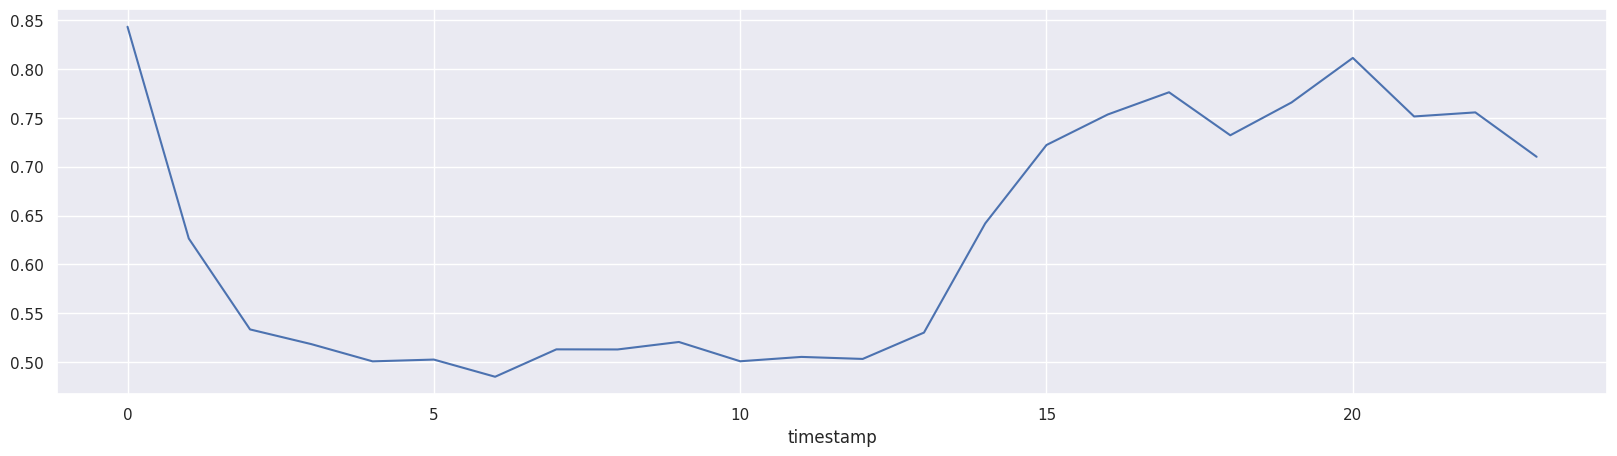

In [46]:
# Plot average spread per hour.
resampled_bid_ask_btc["quoted_spread"].groupby(
    resampled_bid_ask_btc.timestamp.dt.hour
).mean().plot()

<AxesSubplot: xlabel='timestamp'>

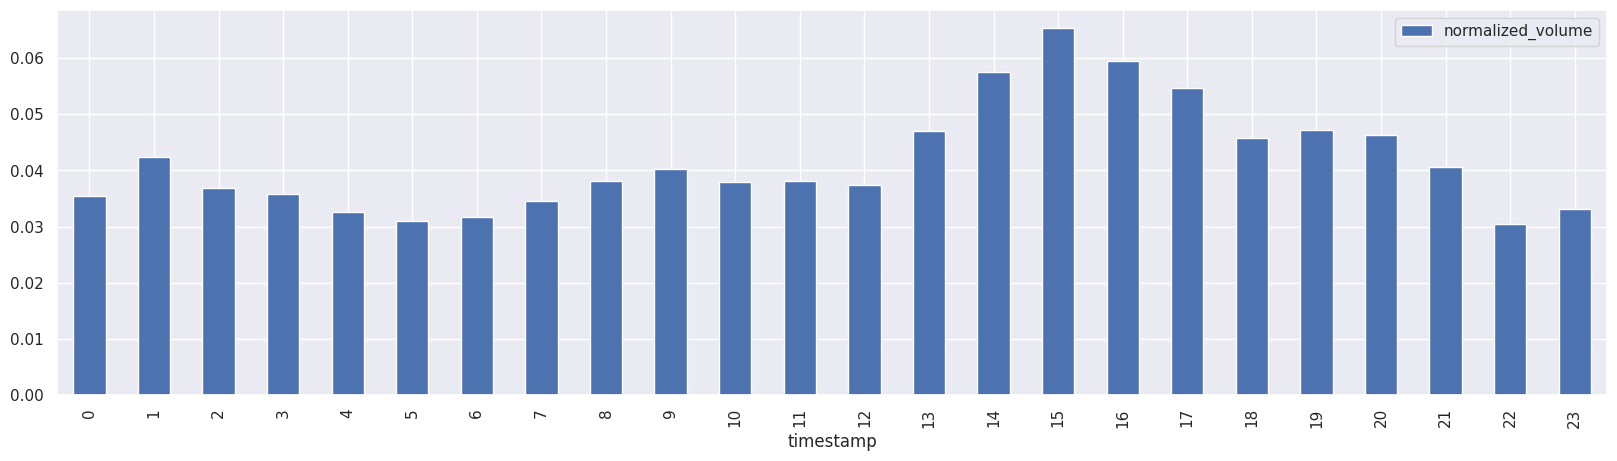

In [47]:
# Plot normalized volume by hour (for reference with average spread).
resampled_ohlcv_btc_by_hour[["normalized_volume"]].plot(kind="bar")

In [48]:
# Get total bid price by day.
by_day_bid_ask_btc = get_sum_bid_price_by_day(resampled_bid_ask_btc)
by_day_bid_ask_eth = get_sum_bid_price_by_day(resampled_bid_ask_eth)

<AxesSubplot: xlabel='timestamp'>

<AxesSubplot: xlabel='timestamp'>

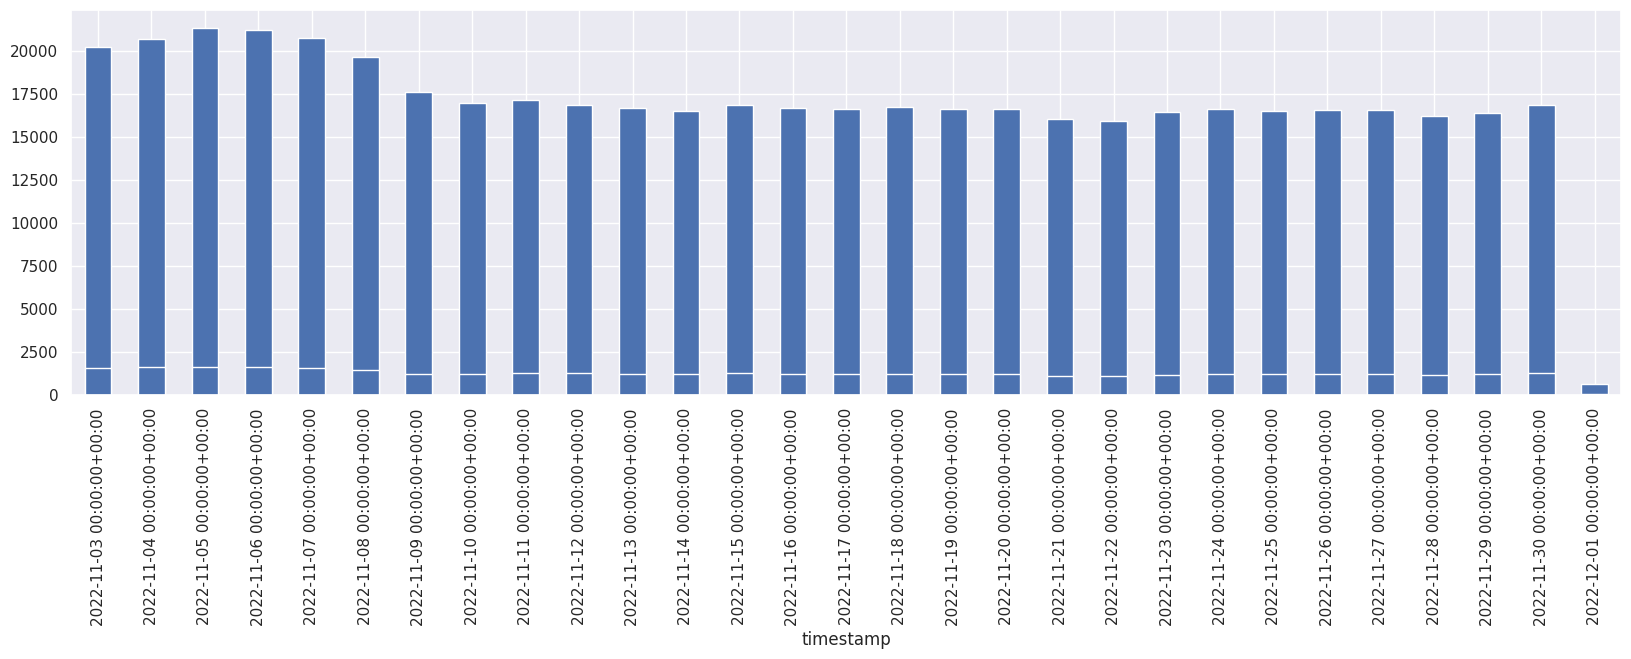

In [49]:
display(by_day_bid_ask_btc.plot(kind="bar"))
display(by_day_bid_ask_eth.plot(kind="bar"))

### Execution flow simulation

In [50]:
dag = create_execution_pipeline(60)
df_out = dag.run_leq_node("compute_bid_ask_execution_quality", "fit")["df_out"]
df_out = df_out[df_out.index <= pd.Timestamp("2022-11-30 23:59:59+00:00")]

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


<AxesSubplot: xlabel='timestamp'>

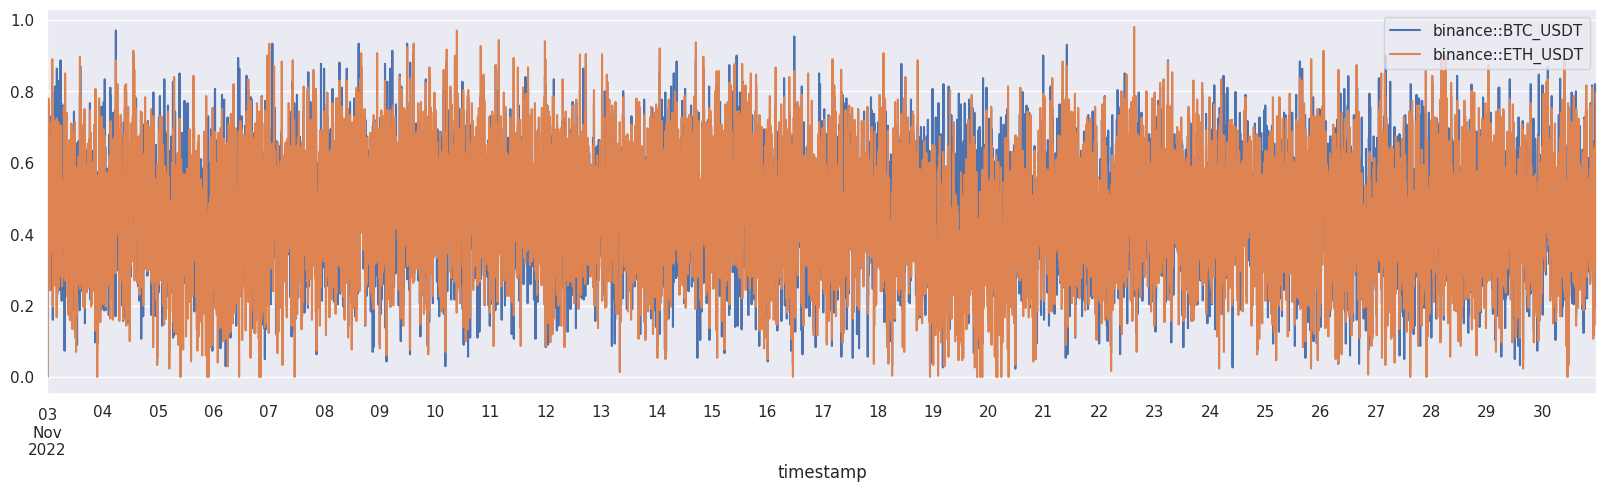

In [51]:
df_out["limit_sell_executed"].plot()

In [52]:
df_out_btc, df_out_eth = apply_weights_to_execution_pipeline(df_out)

In [53]:
df_out_btc["weighted_sell_trade_price"].resample(rule="D").sum()

timestamp
2022-11-03 00:00:00+00:00    242310.326438
2022-11-04 00:00:00+00:00    248741.313822
2022-11-05 00:00:00+00:00    255932.811050
2022-11-06 00:00:00+00:00    254644.459828
2022-11-07 00:00:00+00:00    249172.223952
2022-11-08 00:00:00+00:00    234539.965981
2022-11-09 00:00:00+00:00    209807.581158
2022-11-10 00:00:00+00:00    204356.798791
2022-11-11 00:00:00+00:00    205027.965763
2022-11-12 00:00:00+00:00    202287.749559
2022-11-13 00:00:00+00:00    199671.078625
2022-11-14 00:00:00+00:00    197741.753507
2022-11-15 00:00:00+00:00    202101.452067
2022-11-16 00:00:00+00:00    200058.598905
2022-11-17 00:00:00+00:00    199282.479514
2022-11-18 00:00:00+00:00    200748.780944
2022-11-19 00:00:00+00:00    199737.392284
2022-11-20 00:00:00+00:00    199065.300309
2022-11-21 00:00:00+00:00    192526.485781
2022-11-22 00:00:00+00:00    191662.703472
2022-11-23 00:00:00+00:00    197588.152705
2022-11-24 00:00:00+00:00    199165.400641
2022-11-25 00:00:00+00:00    197946.381212
2

In [54]:
# Get daily sell price and total bid price, weighted by average hourly volume.
sell_trade_price_eth = (
    df_out_eth["weighted_sell_trade_price"].resample(rule="D").sum()
)

bid_price_eth_by_day = (
    resampled_bid_ask_eth.set_index("timestamp")["weighted_bid_price"]
    .resample(rule="D")
    .sum()
)

<AxesSubplot: xlabel='timestamp'>

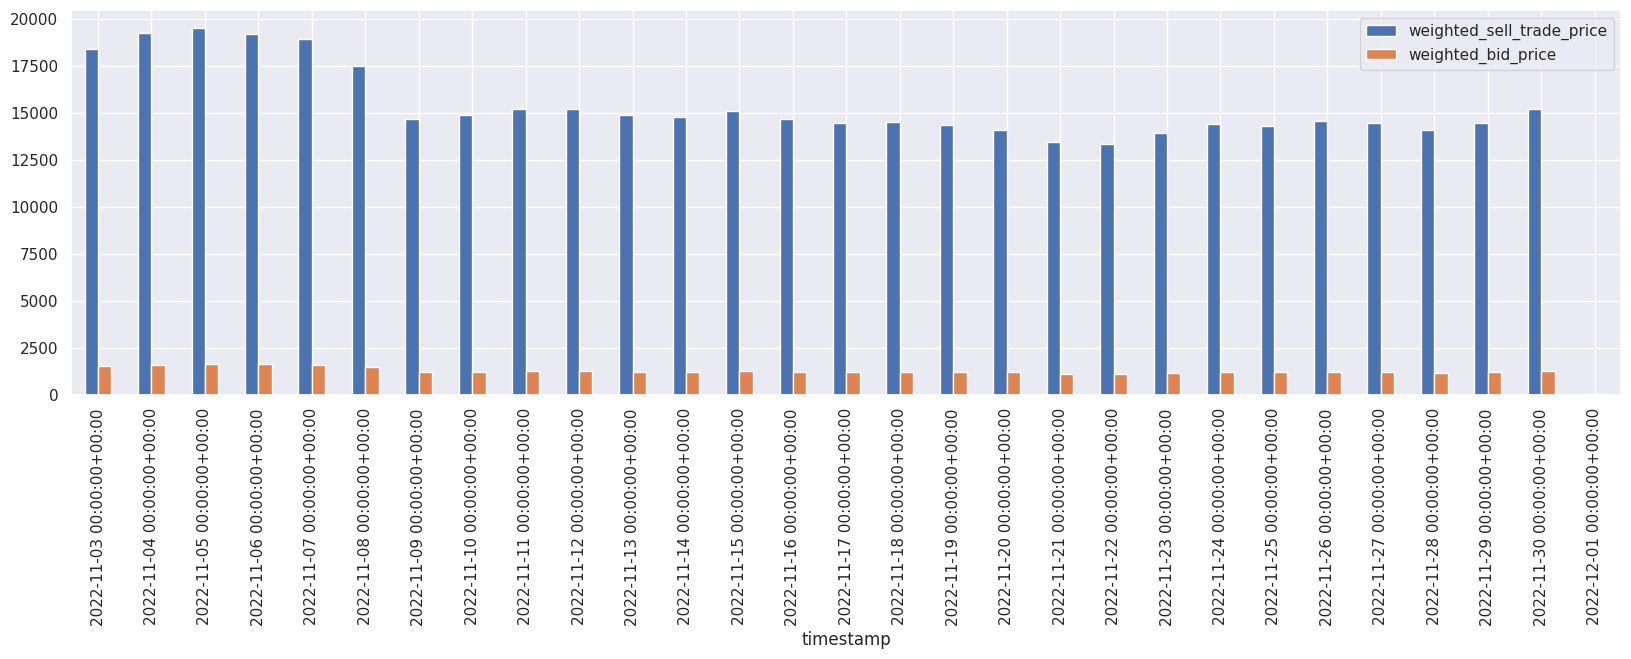

In [55]:
pd.concat([sell_trade_price_eth, bid_price_eth_by_day], axis=1).plot(kind="bar")

### Sanity check up to `generate_limit_orders`

In [56]:
limit_order_check = dag.run_leq_node("generate_limit_orders", "fit")["df_out"]

run_leq_node:   0%|          | 0/2 [00:00<?, ?it/s]

In [57]:
limit_order_check

buy_limit_order_price                     buy_trade_price                   limit_buy_executed                   limit_sell_executed                   sell_limit_order_price                    sell_trade_price                           bid_price                           ask_price                            bid_size                            ask_size                       quoted_spread                  
                              binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT  binance::BTC_USDT binance::ETH_USDT   binance::BTC_USDT binance::ETH_USDT      binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                        
2022-11-03 00:00:00+00:00             20151.270          1518.335               NaN               NaN              False             False               False             False               20151.89           1518.34               NaN               NaN          20150.65           1518.33          20151.89           1518.34           0.00995            4.2593           0.95464           18.2936              1.24              0.01
2022-11-03 00:00:01+00:00             20151.270          1518.335               NaN               NaN              False             False               False             False               20151.89           1518.34               NaN               NaN          20151.01           1518.33          20152.00           1518.34           0.00470            3.7999           0.00100           19.7538              0.99              0.01
2022-11-03 00:00:02+00:00             20151.270          1518.335               NaN               NaN              False             False               False             False               20151.89           1518.34               NaN               NaN          20150.28           1518.33          20151.39           1518.34           0.04457           37.6907           0.02819           13.6870              1.11              0.01
2022-11-03 00:00:03+00:00             20151.270          1518.335               NaN               NaN              False             False               False             False               20151.89           1518.34               NaN               NaN          20150.52           1518.33          20151.35           1518.34           0.01462           36.7551           0.03752           12.7150              0.83              0.01
2022-11-03 00:00:04+00:00             20151.270          1518.335               NaN               NaN              False             False               False             False               20151.89           1518.34               NaN               NaN          20151.70           1518.33          20153.08           1518.34           0.03606           33.1894           0.00184           14.2771              1.38              0.01
...                                         ...               ...               ...               ...                ...               ...                 ...               ...                    ...               ...               ...               ...               ...               ...               ...               ...               ...               ...               ...               ...               ...               ...
2022-11-30 23:59:55+00:00             17164.265          1294.485               NaN               NaN              False

In [58]:
limit_order_check.buy_limit_order_price.isna().sum()

binance::BTC_USDT     1460
binance::ETH_USDT    47800
dtype: int64

### Check results with different subsamples

In [59]:
frequencies = [1, 60, 300, 900, 3600]
result_dict = {}
for f in frequencies:
    dag = create_execution_pipeline(f)
    df = dag.run_leq_node("compute_bid_ask_execution_quality", "fit")["df_out"]
    result_dict[f] = df

run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


run_leq_node:   0%|          | 0/4 [00:00<?, ?it/s]

/app/amp/helpers/hdbg.py:311: PerformanceWarning: indexing past lexsort depth may impact performance.
  cond = value in valid_values


In [60]:
result_dict[60]

bid_ask_midpoint                   buy_trade_midpoint_slippage_bps                   buy_trade_midpoint_slippage_notional                   buy_trade_price_improvement_bps                   buy_trade_price_improvement_notional                   buy_trade_price_improvement_spread_pct                   sell_trade_midpoint_slippage_bps                   sell_trade_midpoint_slippage_notional                   sell_trade_price_improvement_bps                   sell_trade_price_improvement_notional                   sell_trade_price_improvement_spread_pct                          spread_bps                     spread_notional                           ask_price                           bid_price                   buy_limit_order_price                     buy_trade_price                   limit_buy_executed                   limit_sell_executed                   sell_limit_order_price                    sell_trade_price                  
                          binance::BTC_USDT binance::ETH_USDT               binance::BTC_USDT binance::ETH_USDT                    binance::BTC_USDT binance::ETH_USDT               binance::BTC_USDT binance::ETH_USDT                    binance::BTC_USDT binance::ETH_USDT                      binance::BTC_USDT binance::ETH_USDT                binance::BTC_USDT binance::ETH_USDT                     binance::BTC_USDT binance::ETH_USDT                binance::BTC_USDT binance::ETH_USDT                     binance::BTC_USDT binance::ETH_USDT                       binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT     binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT  binance::BTC_USDT binance::ETH_USDT   binance::BTC_USDT binance::ETH_USDT      binance::BTC_USDT binance::ETH_USDT binance::BTC_USDT binance::ETH_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2022-11-03 00:00:00+00:00      20151.270000       1518.335000                             NaN               NaN                                  NaN               NaN                             NaN               NaN                                  NaN               NaN                                    NaN               NaN                              NaN               NaN                                   NaN               NaN                              NaN               NaN                                   NaN               NaN                                     NaN               NaN          0.615346          0.065862          1.240000          0.010000      20151.890000       1518.340000      20150.650000       1518.330000          20151.270000       1518.335000               NaN               NaN           0.000000          0.000000            0.000000          0.000000           20151.890000       1518.340000               NaN               NaN
2022-11-03 00:05:00+00:00      20147.799883       1517.898020                        0.696035          0.900863                        

## Spot market depth and impact

In [61]:
# This section relies upon test data.
assert 0

AssertionError: 

In [62]:
epoch_unit = "s"
# Convert dates to unix timestamps.
start = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp("2022-11-01T00:00:00+00:00"), epoch_unit
)
end = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp("2022-11-01T23:59:59+00:00"), unit=epoch_unit
)
# Define filters for data period.
filters = [("timestamp", ">=", start), ("timestamp", "<=", end)]
filters.append(("currency_pair", "in", ["BTC_USDT", "ETH_USDT"]))
base_columns = ["timestamp", "currency_pair"]
bid_ask_cols = ["bid_size", "bid_price", "ask_size", "ask_price"]
level_columns = [
    ba_col + f"_l{l}"
    for l in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for ba_col in bid_ask_cols
]
columns = base_columns + level_columns
src_dir = "s3://cryptokaizen-data-test/v3/bulk/manual/downloaded_1sec/parquet/bid_ask/spot/v3/crypto_chassis/binance/v1_0_0"
data = hparque.from_parquet(
    src_dir, columns=columns, filters=filters, aws_profile="ck"
)

In [63]:
def get_book_slice(
    data: pd.DataFrame,
    timestamp: pd.Timestamp,
    currency_pair: str,
    max_depth: int,
) -> pd.DataFrame:
    data = data[data["currency_pair"] == currency_pair]
    data = data.loc[timestamp]
    bid_srs = {}
    bid_size_srs = {}
    ask_srs = {}
    ask_size_srs = {}
    for level in range(1, max_depth + 1):
        bid_srs[level] = data.loc["bid_price_l" + str(level)]
        bid_size_srs[level] = data.loc["bid_size_l" + str(level)]
        ask_srs[level] = data.loc["ask_price_l" + str(level)]
        ask_size_srs[level] = data.loc["ask_size_l" + str(level)]
    bid_srs = pd.Series(bid_srs, name="bid")
    bid_size_srs = pd.Series(bid_size_srs, name="bid_size")
    ask_srs = pd.Series(ask_srs, name="ask")
    ask_size_srs = pd.Series(ask_size_srs, name="ask_size")
    df = pd.concat([bid_srs, bid_size_srs, ask_srs, ask_size_srs], axis=1)
    return df

In [64]:
data.head()

,timestamp,currency_pair,bid_size_l1,bid_price_l1,ask_size_l1,ask_price_l1,bid_size_l2,bid_price_l2,ask_size_l2,ask_price_l2,bid_size_l3,bid_price_l3,ask_size_l3,ask_price_l3,bid_size_l4,bid_price_l4,ask_size_l4,ask_price_l4,bid_size_l5,bid_price_l5,ask_size_l5,ask_price_l5,bid_size_l6,bid_price_l6,ask_size_l6,ask_price_l6,bid_size_l7,bid_price_l7,ask_size_l7,ask_price_l7,bid_size_l8,bid_price_l8,ask_size_l8,ask_price_l8,bid_size_l9,bid_price_l9,ask_size_l9,ask_price_l9,bid_size_l10,bid_price_l10,ask_size_l10,ask_price_l10
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:00:00+00:00,1667260800,BTC_USDT,0.00519,20491.30,0.00244,20491.69,0.03850,20491.17,0.02000,20491.98,0.00244,20491.02,0.02000,20492.00,0.00104,20491.01,0.07116,20492.05,0.05345,20490.94,0.05000,20492.09,0.01148,20490.91,0.03134,20492.77,0.00519,20490.87,0.02410,20492.78,0.03562,20490.85,0.04000,20492.79,0.00519,20490.78,0.02000,20492.80,0.06920,20490.74,0.16590,20492.92
2022-11-01 00:00:01+00:00,1667260801,BTC_USDT,3.13200,20491.09,0.12963,20491.96,0.17950,20490.61,0.00748,20492.00,0.00499,20490.60,0.00243,20492.08,0.05203,20490.54,0.01704,20492.20,0.16832,20490.53,0.05108,20492.28,0.23421,20490.50,0.07027,20492.59,0.00244,20490.37,0.00853,20492.62,0.00160,20490.36,0.01120,20492.75,0.03087,20490.34,0.08286,20492.92,0.06174,20490.33,0.16572,20492.93
2022-11-01 00:00:02+00:00,1667260802,BTC_USDT,0.01886,20490.56,0.00272,20491.90,0.01550,20490.55,0.05203,20491.92,0.00499,20490.54,0.00867,20491.93,0.10506,20490.50,0.28504,20491.94,0.03087,20490.41,0.16832,20491.95,0.01658,20490.38,0.00163,20492.00,0.00160,20490.36,0.00057,20492.01,0.00853,20490.32,0.00213,20492.04,0.00852,20490.27,0.00899,20492.05,0.01460,20490.21,0.01948,20492.09
2022-11-01 00:00:03+00:00,1667260803,BTC_USDT,0.00970,20491.61,0.00056,20492.13,0.00853,20491.06,0.00450,20492.35,0.00495,20491.00,0.06093,20492.36,0.45378,20490.30,0.07808,20492.37,0.20594,20490.29,0.01217,20492.38,0.03127,20490.26,0.00585,20492.50,0.19955,20490.23,0.01264,20492.55,0.00852,20490.17,0.04275,20492.70,0.00933,20490.12,0.00080,20492.75,0.26952,20490.10,0.03087,20492.81
2022-11-01 00:00:04+00:00,1667260804,BTC_USDT,0.00970,20490.80,0.04642,20491.52,0.00244,20490.79,0.00970,20491.54,0.00499,20490.77,0.58276,20491.81,0.01952,20490.11,0.03900,20491.83,0.00471,20490.10,0.01725,20491.98,0.00194,20490.05,0.41188,20491.99,0.48951,20490.04,0.01036,20492.00,0.00163,20490.00,0.00057,20492.01,0.02540,20489.98,0.26952,20492.03,0.01704,20489.91,0.01201,20492.04


In [65]:
timestamp = pd.Timestamp("2022-11-01 00:03:01+00:00")
obslice = get_book_slice(data, timestamp, "BTC_USDT", 10)
display(obslice)
mi = cofinanc.estimate_market_order_price(
    obslice,
    "bid",
    "bid_size",
)
display(mi)

,bid,bid_size,ask,ask_size
1,20463.36,0.03585,20464.08,0.09721
2,20463.35,0.05261,20464.09,0.15000
3,20463.32,0.05031,20464.10,0.01917
4,20463.08,0.23121,20464.73,0.21280
5,20463.07,0.13178,20465.00,0.00244
6,20463.03,0.14657,20465.05,0.61948
7,20463.01,0.02333,20465.06,0.24404
8,20463.00,0.88387,20465.07,0.01000
9,20462.93,0.03087,20465.09,0.01950
10,20462.85,0.03250,20465.16,0.10000


/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))


,price,size,notional,cumulative_size,cumulative_notional,mean_price_through_level,price_degradation_bps
1,20463.36,0.03585,733.611456,0.03585,733.611456,20463.360000,0.000000
2,20463.35,0.05261,1076.576843,0.08846,1810.188299,20463.354053,0.002906
3,20463.32,0.05031,1029.509629,0.13877,2839.697929,20463.341707,0.008939
4,20463.08,0.23121,4731.268727,0.36998,7570.966655,20463.178160,0.088861
5,20463.07,0.13178,2696.623365,0.50176,10267.590020,20463.149753,0.102743
6,20463.03,0.14657,2999.266307,0.64833,13266.856327,20463.122680,0.115973
7,20463.01,0.02333,477.402023,0.67166,13744.258350,20463.118766,0.117886
8,20463.00,0.88387,18086.631810,1.55553,31830.890160,20463.051282,0.150864
9,20462.93,0.03087,631.690649,1.58640,32462.580810,20463.048922,0.152017
10,20462.85,0.03250,665.042625,1.61890,33127.623435,20463.044928,0.153969


In [66]:
def get_price_degradation_and_notional(data, timestamps, symbol):
    price_degradation = {}
    notional = {}
    for timestamp in tqdm(timestamps):
        obslice = get_book_slice(data, timestamp, symbol, 10)
        mi = cofinanc.estimate_market_order_price(
            obslice,
            "bid",
            "bid_size",
        )
        price_degradation[timestamp] = mi["price_degradation_bps"]
        notional[timestamp] = mi["cumulative_notional"]
    mi_curve = pd.concat(price_degradation, axis=1).T
    not_curve = pd.concat(notional, axis=1).T
    return mi_curve, not_curve

In [67]:
hourly_timestamps = [
    pd.Timestamp("2022-11-01 00:00:00+00:00"),
    pd.Timestamp("2022-11-01 01:00:00+00:00"),
    pd.Timestamp("2022-11-01 02:00:00+00:00"),
    pd.Timestamp("2022-11-01 03:00:00+00:00"),
    pd.Timestamp("2022-11-01 04:00:00+00:00"),
    pd.Timestamp("2022-11-01 05:00:00+00:00"),
    pd.Timestamp("2022-11-01 06:00:00+00:00"),
    pd.Timestamp("2022-11-01 07:00:00+00:00"),
    pd.Timestamp("2022-11-01 08:00:00+00:00"),
    pd.Timestamp("2022-11-01 09:00:00+00:00"),
    pd.Timestamp("2022-11-01 10:00:00+00:00"),
    pd.Timestamp("2022-11-01 11:00:00+00:00"),
    pd.Timestamp("2022-11-01 12:00:00+00:00"),
    pd.Timestamp("2022-11-01 13:00:00+00:00"),
    pd.Timestamp("2022-11-01 14:00:00+00:00"),
    pd.Timestamp("2022-11-01 15:00:00+00:00"),
    pd.Timestamp("2022-11-01 16:00:00+00:00"),
    pd.Timestamp("2022-11-01 17:00:00+00:00"),
    pd.Timestamp("2022-11-01 18:00:00+00:00"),
    pd.Timestamp("2022-11-01 19:00:00+00:00"),
    pd.Timestamp("2022-11-01 20:00:00+00:00"),
    pd.Timestamp("2022-11-01 21:00:00+00:00"),
    pd.Timestamp("2022-11-01 22:00:00+00:00"),
    pd.Timestamp("2022-11-01 23:00:00+00:00"),
]

In [68]:
price_degradation, volume = get_price_degradation_and_notional(
    data, hourly_timestamps, "BTC_USDT"
)

  0%|          | 0/24 [00:00<?, ?it/s]

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

In [69]:
price_degradation.mean()

1     0.000000
2     0.052617
3     0.074079
4     0.087989
5     0.102757
6     0.126077
7     0.137859
8     0.150365
9     0.168307
10    0.180751
dtype: float64

In [70]:
volume.sum()

1      23373.982123
2      53938.364927
3     214510.019661
4     239408.636074
5     269600.342583
6     315186.073846
7     376556.977716
8     408675.300608
9     486272.491356
10    506586.325453
dtype: float64

In [71]:
1.0018**24

1.0441061563232394

In [72]:
mi_curve, not_curve = get_price_degradation_and_notional(
    data, data.index[:1000], "BTC_USDT"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dassert_isinstance(df.index, (pd.RangeIndex, pd.Int64Index))
/app/amp/core/finance/market_impact.py:33: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  hdbg.dasse

<AxesSubplot: >

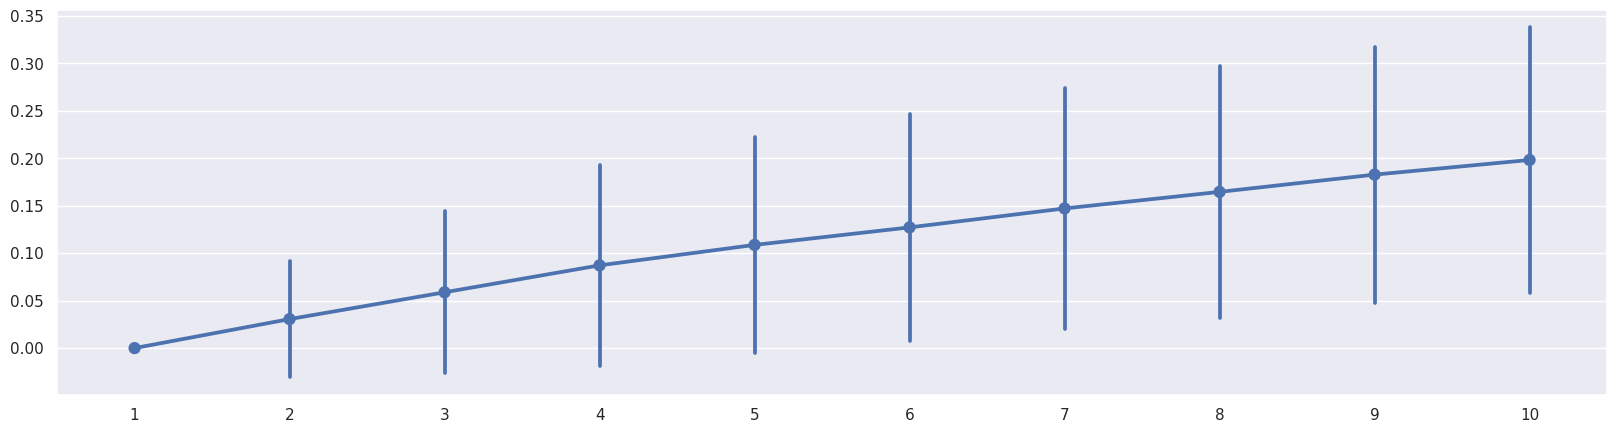

In [73]:
sns.pointplot(mi_curve, errorbar="sd")

<AxesSubplot: >

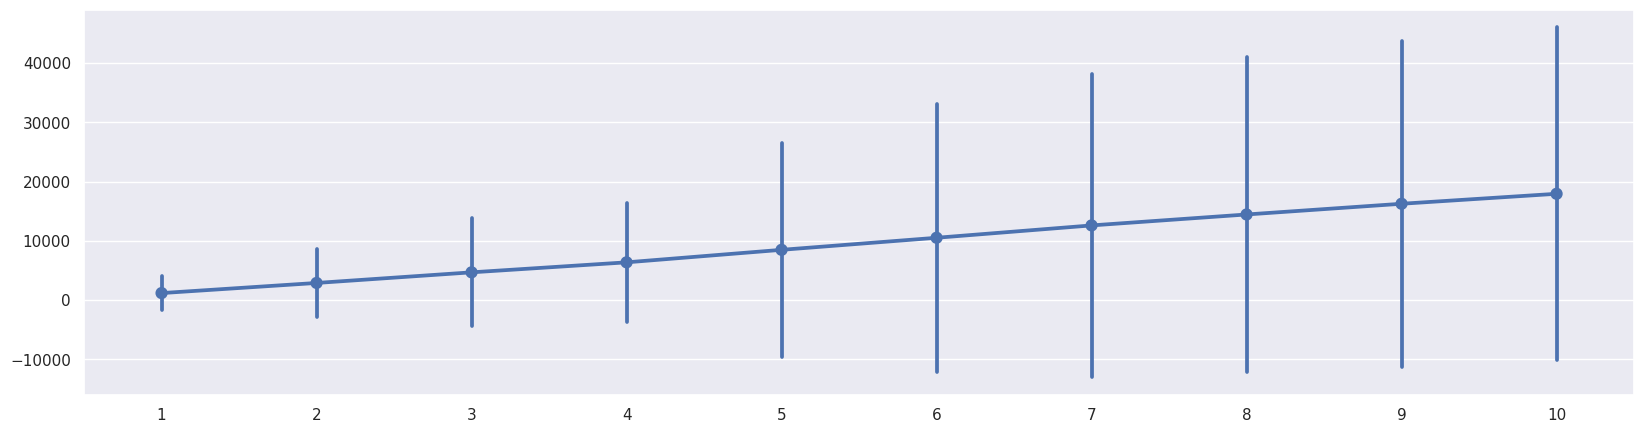

In [74]:
sns.pointplot(not_curve, errorbar="sd")